# From unstructured text to visualization
## Political science course

In this notebook, we will explore different ways of visualizing unstructured text data. This third notebook will introduce word embeddings and AI approaches.
## Word Embeddings
Word embeddings are a way to represent words as numbers (vectors) so that computers can understand them.

Essentially, they capture the meaning of a word by placing words with similar meanings closer together in a numerical space. For example, the word "king" would be numerically close to "queen" and "man" would be close to "woman" because they're related concepts.

This numerical representation allows machine learning models to process text much more effectively.

Run the following cell to install gensim, a library for similarity in (static) embedding spaces, and download a medium-size pretrained model.


In [ ]:
!pip install gensim
from gensim import downloader
model = downloader.load('glove-wiki-gigaword-50')

[==================================================] 100.0% 66.0/66.0MB downloaded


The following code shows the $n$ most similar words in the embedding space to the target word. Feel free to change the word and $n$.

In [ ]:
target_word = "climate"
n = 5
model.most_similar(target_word, topn=n)

[('warming', 0.8264477252960205),
 ('environment', 0.8150415420532227),
 ('economic', 0.7480109930038452),
 ('environmental', 0.7435222864151001),
 ('conditions', 0.7384123206138611)]

The following code shows the most similar word given a list of _positive_ and _negative_ words. _Positive_ words are words that the word should be _similar_ to, while _negative_ words are words that the word should **not** be similar to. Feel free to play around with the words.

In [ ]:
positive = ["king", "woman"] # we want something close to "king" and "woman"
negative = ["man"] # but we don't want it to be close to "man"
model.most_similar(positive=positive, negative=negative, topn=1)

[('queen', 0.8523604273796082)]

The underlying vectors are high-dimensional (300 dimensions), so now we will explore a projections into 2D space. This projection can show how close words are in the semantic space. However, since it is a projection, a lot of information is lost, so the results should be interpreted **with caution**.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from itertools import chain

def _get_vectors_from_model(words, model):
    """Return (in_vocab_words, vectors, oov_words) from a list of words."""
    in_vocab = []
    vecs = []
    oov = []
    keyset = set(getattr(model, "key_to_index", getattr(model, "vocab", {})).keys()
                 if hasattr(model, "key_to_index") or hasattr(model, "vocab") else [])
    for w in words:
        if w in keyset or hasattr(model, "get_vector"):
            try:
                v = model.get_vector(w)
                in_vocab.append(w)
                vecs.append(v)
            except KeyError:
                oov.append(w)
        else:
            # fallback attempt
            try:
                v = model[w]
                in_vocab.append(w)
                vecs.append(v)
            except KeyError:
                oov.append(w)
    if not vecs:
        raise ValueError("None of the provided words were found in the model vocabulary.")
    X = np.vstack(vecs).astype(float)
    # unit-normalize (so cosine similarity ~ Euclidean)
    X /= (np.linalg.norm(X, axis=1, keepdims=True) + 1e-12)
    return in_vocab, X, oov

def tsne_words(
    model,
    words_or_groups,
    perplexity=10,
    random_state=42,
    annotate=True,
    group_markers=("o", "^", "s", "D", "P", "X", "*", "v")
):
    """
    Project word vectors to 2D with t-SNE and plot.

    Parameters
    ----------
    model : gensim.models.KeyedVectors
        Preloaded embeddings model.
    words_or_groups : list[str] | dict[str, list[str]]
        Either a flat list of words OR a dict of {group_name: [word, ...]}.
    perplexity : int
        t-SNE perplexity (should be < number_of_points).
    random_state : int
        RNG seed for reproducibility.
    annotate : bool
        If True, add text labels to points.
    group_markers : tuple[str]
        Cycle of markers for groups (only used when groups dict is provided).
    """
    # Flatten words and remember groups if provided
    if isinstance(words_or_groups, dict):
        groups = words_or_groups
        words = list(chain.from_iterable(groups.values()))
        group_of_word = {}
        for gi, (gname, gwords) in enumerate(groups.items()):
            for w in gwords:
                group_of_word[w] = (gname, gi)
    else:
        groups = None
        words = list(words_or_groups)

    # Get vectors
    in_vocab, X, oov = _get_vectors_from_model(words, model)

    # Adjust perplexity if necessary
    n = len(in_vocab)
    if perplexity >= n:
        perplexity = max(5, n // 3)

    # t-SNE
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        learning_rate="auto",
        init="pca",
        random_state=random_state
    )
    xy = tsne.fit_transform(X)

    # Plot
    plt.figure(figsize=(8, 6))
    if groups is None:
        # Single set
        plt.scatter(xy[:, 0], xy[:, 1])
        if annotate:
            for i, w in enumerate(in_vocab):
                plt.text(xy[i, 0] + 0.5, xy[i, 1] + 0.5, w, fontsize=9)
        plt.title("Word Embedding Space (t-SNE)")
    else:
        # Grouped plot with different markers
        marker_cycle = list(group_markers)
        used = {}
        for i, w in enumerate(in_vocab):
            gname, gi = group_of_word.get(w, ("(Other)", len(groups)))
            marker = used.get(gname)
            if marker is None:
                marker = marker_cycle[gi % len(marker_cycle)]
                used[gname] = marker
            plt.scatter(xy[i, 0], xy[i, 1], marker=marker, label=gname if gname not in used or used[gname] == marker and gname not in plt.gca().get_legend_handles_labels()[1] else "")
            if annotate:
                plt.text(xy[i, 0] + 0.5, xy[i, 1] + 0.5, w, fontsize=9)
        plt.title("Word Embedding Space by Group (t-SNE)")
        plt.legend()

    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.tight_layout()
    plt.show()

    if oov:
        print(f"OOV words (not in model): {sorted(set(oov))}")

Let us generate a simple projection using a set of words.

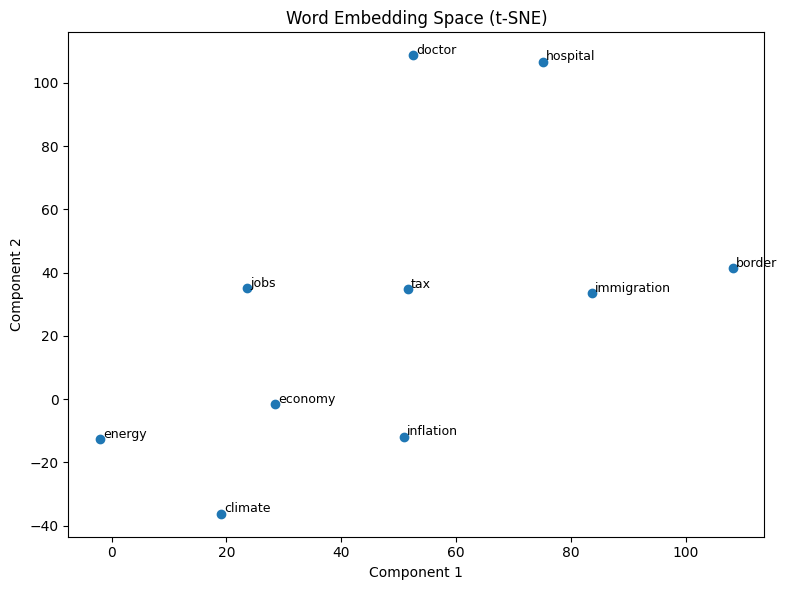

In [ ]:
tsne_words(model, ["economy","inflation","jobs","tax","climate","energy","hospital","doctor","immigration","border"])

We can also group words by category. Are the categories close in space?

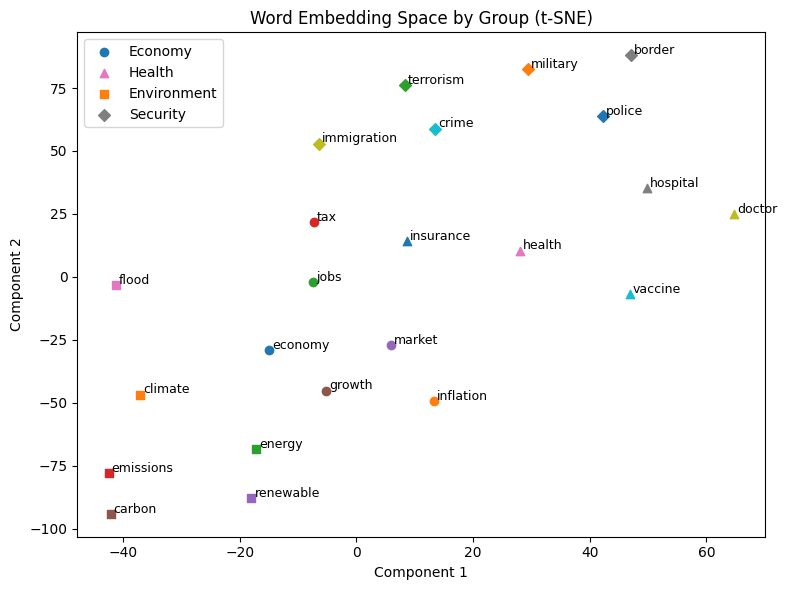

OOV words (not in model): ['covid']


In [ ]:
words_by_group = {
     "Economy": ["economy","inflation","jobs","tax","market","growth"],
     "Health": ["health","covid","hospital","doctor","vaccine","insurance"],
     "Environment": ["climate","energy","emissions","renewable","carbon","flood"],
     "Security": ["border","immigration","crime","police","military","terrorism"]
 }

tsne_words(model, words_by_group, perplexity=10, annotate=True)

## AI approaches

The following block defines a chatbot using an open small language model from the Qwen family.

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

class QwenChatbot:
    def __init__(self, model_name="Qwen/Qwen3-0.6B"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForCausalLM.from_pretrained(model_name)
        self.history = []

    def generate_response(self, user_input):
        messages = self.history + [{"role": "user", "content": user_input}]

        text = self.tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )

        inputs = self.tokenizer(text, return_tensors="pt")
        response_ids = self.model.generate(**inputs, max_new_tokens=32768)[0][len(inputs.input_ids[0]):].tolist()
        response = self.tokenizer.decode(response_ids, skip_special_tokens=True)

        # Update history
        self.history.append({"role": "user", "content": user_input})
        self.history.append({"role": "assistant", "content": response})

        return response

Let's ask our chatbot a question.

In [ ]:
chatbot = QwenChatbot()
prompt = "I have data from people's opinion about democratic and republican party. How can I visualize this data /no_think"
response = chatbot.generate_response(prompt)
print(response)

<think>
Okay, so I need to visualize data from people's opinions about democratic and republican parties. Let me start by understanding what kind of data I have. Are they just two categories, or are there more variables? The user mentioned "people's opinion," so maybe they have numerical data or qualitative data. For example, maybe they rated the parties on a scale from 1 to 5 or included some other attributes.

First, I should figure out the structure of the data. Are there two main categories: democratic and republican? Or are there more variables? For instance, maybe each person's opinion is a combination of factors like their preference for the party, their level of support, etc. If it's two categories, perhaps a bar chart or a pie chart would work. But if there are more variables, maybe a heatmap would show the distribution of each variable.

I should consider different visualization techniques. A bar chart could show the frequency or distribution of each party. A pie chart might 